#Project

#1. Loading the data

In [ ]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/dsl_project/'

df_dev = pd.read_csv(folder_path + 'development.csv')
df_eval = pd.read_csv(folder_path + 'evaluation.csv')

Mounted at /content/drive


In [ ]:
print("Development:", df_dev.shape)
print("Evaluation:", df_eval.shape)

Development: (2933, 20)
Evaluation: (691, 19)


In [ ]:
print("Development:", df_dev.columns)
print("Evaluation:", df_eval.columns)

Development: Index(['Id', 'sampling_rate', 'age', 'gender', 'ethnicity', 'mean_pitch',
       'max_pitch', 'min_pitch', 'jitter', 'shimmer', 'energy', 'zcr_mean',
       'spectral_centroid_mean', 'tempo', 'hnr', 'num_words', 'num_characters',
       'num_pauses', 'silence_duration', 'path'],
      dtype='object')
Evaluation: Index(['Id', 'sampling_rate', 'gender', 'ethnicity', 'mean_pitch', 'max_pitch',
       'min_pitch', 'jitter', 'shimmer', 'energy', 'zcr_mean',
       'spectral_centroid_mean', 'tempo', 'hnr', 'num_words', 'num_characters',
       'num_pauses', 'silence_duration', 'path'],
      dtype='object')


In [ ]:
df_dev.describe()

,Id,sampling_rate,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,hnr,num_words,num_characters,num_pauses,silence_duration
count,2933.000000,2933.0,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,1466.000000,22050.0,27.897886,1189.536569,3779.570485,146.934930,0.021190,0.107741,0.005208,0.104774,2176.369847,-74.526288,41.307535,167.936243,12.423116,13.501159
std,846.828495,0.0,13.093316,414.193673,532.847869,3.757917,0.006626,0.029005,0.006074,0.051646,578.925294,38.446856,32.782431,133.816974,14.273205,10.839142
min,0.000000,22050.0,6.000000,346.974330,935.515560,145.349140,0.007292,0.045205,0.000028,0.015947,692.116731,-193.693345,0.000000,0.000000,1.000000,0.668345
25%,733.000000,22050.0,19.000000,818.922360,3948.234400,145.419140,0.016734,0.087378,0.001960,0.060733,1740.756716,-104.555692,4.000000,14.000000,1.000000,1.732925
50%,1466.000000,22050.0,23.000000,1208.998300,3998.397200,145.622010,0.020525,0.104697,0.003716,0.098964,2150.814043,-84.415550,69.000000,281.000000,8.000000,17.368526
75%,2199.000000,22050.0,32.000000,1523.777700,3999.485400,146.820890,0.024558,0.124993,0.006338,0.139559,2566.190670,-40.339359,69.000000,281.000000,20.000000,21.408798
max,2932.000000,22050.0,97.000000,2724.892800,3999.792500,202.040700,0.096153,0.265167,0.129114,0.335976,4144.132595,12.403661,69.000000,281.000000,97.000000,83.777596


#2. Data preprocessing

##2.1 Extracting new features from the audios

In [ ]:
dev_files = os.listdir('/content/drive/MyDrive/dsl_project/audios/dev')
eval_files = os.listdir('/content/drive/MyDrive/dsl_project/audios/eval')

In [ ]:
y, sr = librosa.load('/content/drive/MyDrive/dsl_project/audios/dev/' + dev_files[1])
y, len(y), sr

(array([2.6405789e-05, 2.8491020e-05, 2.9367395e-05, ..., 3.6826590e-04,
        7.2118896e-04, 5.0457334e-04], dtype=float32),
 631323,
 22050)

In [ ]:
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

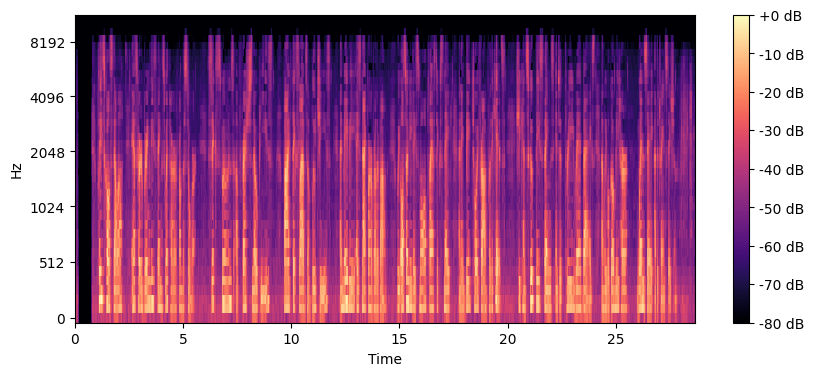

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.savefig('audios.svg')

In [ ]:
def extract_features(file_path):
    y, sr = librosa.load(file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    features = np.concatenate([
        np.mean(log_spectrogram, axis=1),
        np.std(log_spectrogram, axis=1),
    ])
    return features

In [ ]:
def load_data(audio_files, set_name="eval"):
    features = []
    for file_name in tqdm(audio_files):
        if file_name.endswith(".wav"):
            file_number = int(file_name.replace(".wav", ""))
            file_path = os.path.join("/content/drive/MyDrive/dsl_project/audios", set_name, file_name)

            feature_vector = extract_features(file_path)
            feature_vector = np.insert(feature_vector, 0, file_number)
            features.append(feature_vector)
    return np.array(features)

In [ ]:
X_dev = load_data(dev_files,set_name="dev")
X_dev.shape

  0%|          | 0/2933 [00:00<?, ?it/s]

(2933, 81)

In [ ]:
X_eval = load_data(eval_files, set_name="eval")
X_eval.shape

  0%|          | 0/691 [00:00<?, ?it/s]

(691, 81)

In [ ]:
X_dev_aud = pd.DataFrame(X_dev)
X_dev_aud[0] = X_dev_aud[0].astype(int)
X_dev_aud = X_dev_aud.rename(columns={0: 'Id'})
X_dev_aud['Id'] = X_dev_aud['Id'] - 1

In [ ]:
X_eval_aud = pd.DataFrame(X_eval)
X_eval_aud[0] = X_eval_aud[0].astype(int)
X_eval_aud = X_eval_aud.rename(columns={0: 'Id'})
X_eval_aud['Id'] = X_eval_aud['Id'] - 1

In [ ]:
df_dev_new = pd.merge(df_dev, X_dev_aud, on='Id', how='inner')
df_eval_new = pd.merge(df_eval, X_eval_aud, on='Id', how='inner')

Checking the shape of the new data

In [ ]:
df_new_sorted = df_dev_new.sort_values(by='Id')
df_new_sorted.head(20)
df_dev_new.shape

(2933, 100)

In [ ]:
df_eval_new.shape

(691, 99)

Merging the data into one dataset

In [ ]:
df = pd.concat([df_dev_new, df_eval_new], axis=0)

##2.2 Preprocessing

Checking the number of values that are NaN

In [ ]:
null_counts = df.isna().sum()
print(null_counts[null_counts > 0])

age    691
dtype: int64


The distribution of the target value:

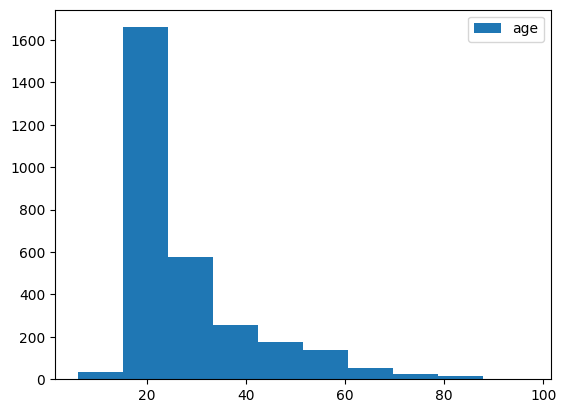

In [ ]:
plt.hist(df['age'], bins=10, label='age')
plt.legend()
plt.show()

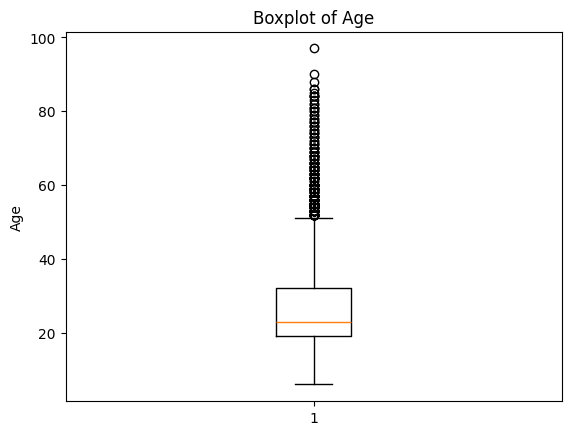

In [ ]:
plt.boxplot(df_dev['age'])
plt.title('Boxplot of Age')
plt.ylabel('Age')
plt.show()

Looking for more anomalities

In [ ]:
df.head(20)

,Id,sampling_rate,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,...,71,72,73,74,75,76,77,78,79,80
0,0,22050,24.0,female,arabic,1821.69060,3999.7170,145.43066,0.013795,0.082725,...,12.535248,11.282123,11.724018,12.197580,12.208367,13.334470,13.832603,13.553086,13.208033,12.224444
1,1,22050,22.5,female,hungarian,1297.81870,3998.8590,145.37268,0.025349,0.096242,...,10.270765,9.169687,7.592702,6.819863,6.774230,7.308309,7.202848,6.891078,6.714294,6.947628
2,2,22050,22.0,female,portuguese,1332.85240,3998.8025,145.42395,0.019067,0.119456,...,11.088596,11.336572,12.188200,12.515166,11.623434,11.249915,11.125043,10.786102,10.507084,10.373445
3,3,22050,22.0,female,english,1430.34990,3998.4510,147.98083,0.017004,0.102389,...,15.700385,14.285404,15.735817,15.042911,14.579581,13.977489,14.235917,14.335194,14.570241,13.548618
4,4,22050,22.0,male,dutch,1688.72340,3998.6113,145.44772,0.028027,0.124831,...,12.664124,13.306779,13.478806,14.362082,13.595493,12.344295,11.097596,10.453747,9.900912,9.728335
5,5,22050,33.0,female,italian,1258.52160,3998.8406,145.61612,0.025642,0.093994,...,12.954975,13.223959,12.538096,12.543228,13.926082,14.458995,14.278573,12.580094,12.509559,13.682910
6,6,22050,18.0,male,french,1789.02590,3999.5728,145.42523,0.022059,0.138322,...,11.748570,11.675613,11.271541,10.683609,10.386152,10.135927,10.158694,9.880252,9.193251,8.828783
7,7,22050,18.0,female,igbo,1042.95260,3989.9595,147.18710,0.013859,0.104579,...,7.496373,9.099419,8.035680,5.243044,3.783435,3.974764,3.210285,4.341969,5.761621,6.677961
8,8,22050,18.0,female,igbo,779.33765,2927.2144,157.62047,0.013921,0.080848,...,5.870090,4.843927,5.019740,5.939303,5.775467,5.723764,6.797437,7.049375,7.281895,7.308315
9,9,22050,18.0,male,igbo,732.35297,3988.0715,147.95331,0.017735,0.114380,...,12.343638,11.647918,9.584024,7.485307,6.310276,7.630616,9.074858,9.775972,9.225427,9.027000


In [ ]:
df.describe()

,Id,sampling_rate,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,...,71,72,73,74,75,76,77,78,79,80
count,3624.000000,3624.0,2933.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,...,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000,3624.000000
mean,1252.255243,22050.0,27.897886,1189.823438,3789.608308,146.869482,0.021214,0.108255,0.005183,0.104839,...,10.113354,10.032319,9.878294,9.611261,9.373193,9.279208,8.735463,7.702696,7.440322,7.292560
std,884.256171,0.0,13.093316,407.814195,518.627816,3.662212,0.006582,0.029089,0.005956,0.051359,...,3.029775,3.245058,3.549039,3.713790,3.703084,3.741758,3.868290,4.405643,4.573264,4.411146
min,0.000000,22050.0,6.000000,346.974330,935.515560,145.349140,0.007292,0.035001,0.000028,0.015947,...,0.860030,1.003626,0.973657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,452.750000,22050.0,19.000000,827.244582,3948.603550,145.414870,0.016797,0.088029,0.001948,0.061844,...,8.074273,7.842737,7.478238,6.887235,6.564900,6.399962,5.688720,3.686960,3.726069,3.846061
50%,1120.500000,22050.0,23.000000,1209.017600,3998.426750,145.603600,0.020549,0.104930,0.003688,0.098847,...,10.161003,10.167230,10.248374,10.060198,9.805278,9.805926,9.013940,7.899580,7.960732,7.834896
75%,2026.250000,22050.0,32.000000,1515.442925,3999.490550,146.708763,0.024551,0.125094,0.006294,0.139046,...,12.096664,12.275332,12.406021,12.351458,12.179057,12.087810,11.742362,11.427652,11.171602,10.810306
max,2932.000000,22050.0,97.000000,2724.892800,3999.792500,202.040700,0.096153,0.265167,0.129114,0.335976,...,21.140236,20.810223,20.289909,20.783779,21.046938,20.303131,19.471643,20.828608,21.045872,20.780638


Converting the field *tempo* from string to float

In [ ]:
df['tempo'] = df['tempo'].str.strip('[]').astype(float)
df.head()

,Id,sampling_rate,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,...,71,72,73,74,75,76,77,78,79,80
0,0,22050,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,...,12.535248,11.282123,11.724018,12.197580,12.208367,13.334470,13.832603,13.553086,13.208033,12.224444
1,1,22050,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,...,10.270765,9.169687,7.592702,6.819863,6.774230,7.308309,7.202848,6.891078,6.714294,6.947628
2,2,22050,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,...,11.088596,11.336572,12.188200,12.515166,11.623434,11.249915,11.125043,10.786102,10.507084,10.373445
3,3,22050,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,...,15.700385,14.285404,15.735817,15.042911,14.579581,13.977489,14.235917,14.335194,14.570241,13.548618
4,4,22050,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,...,12.664124,13.306779,13.478806,14.362082,13.595493,12.344295,11.097596,10.453747,9.900912,9.728335


We have 2 categorical, gender and ethnicity

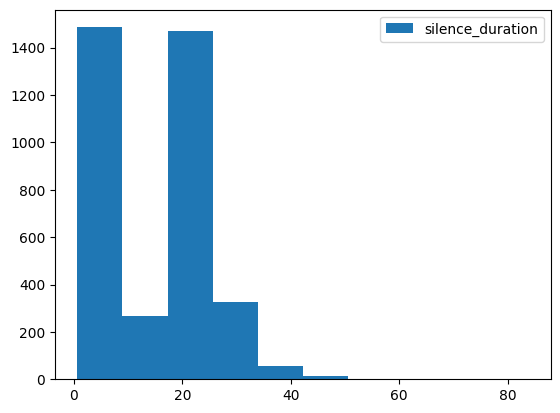

In [ ]:
plt.hist(df['silence_duration'], bins=10, label='silence_duration')
plt.legend()
plt.show()

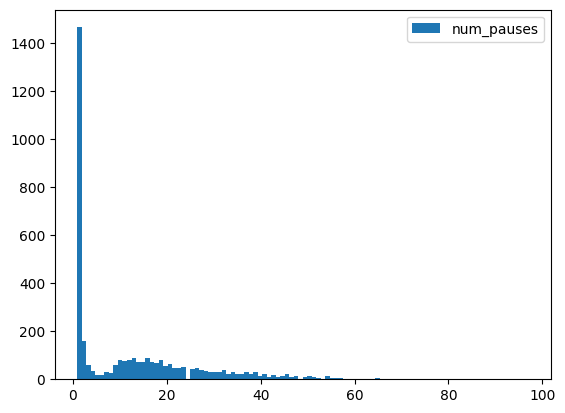

In [ ]:
plt.hist(df['num_pauses'], bins=100, label='num_pauses')
plt.legend()
plt.show()

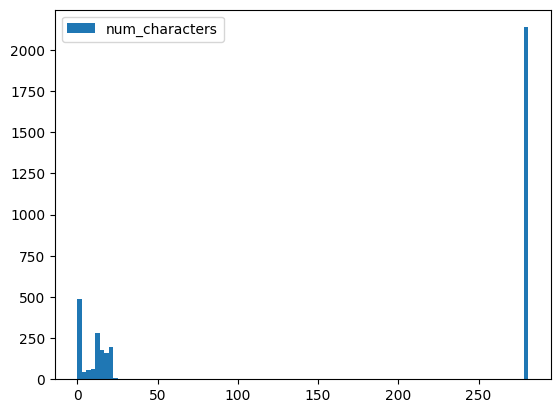

In [ ]:
plt.hist(df['num_characters'], bins=100, label='num_characters')
plt.legend()
plt.show()

We noticed there is a lot of samples that have 0 words, we will check this later

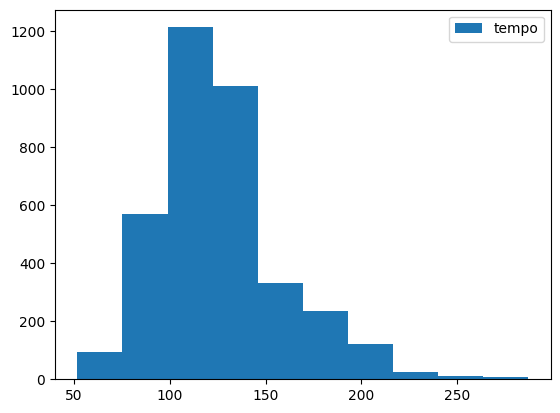

In [ ]:
plt.hist(df['tempo'], bins=10, label='tempo')
plt.legend()
plt.show()

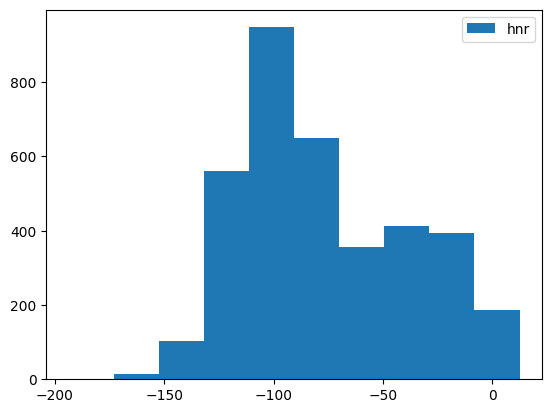

In [ ]:
plt.hist(df['hnr'], bins=10, label='hnr')
plt.legend()
plt.show()

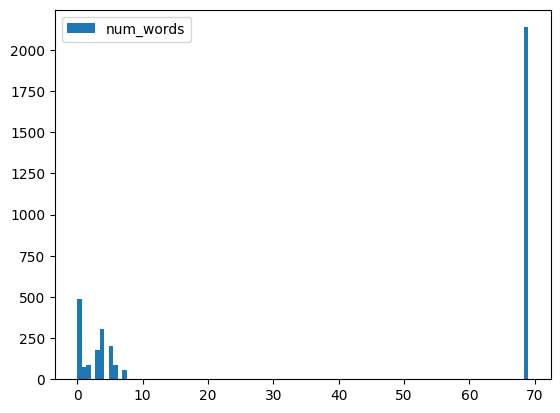

In [ ]:
plt.hist(df['num_words'], bins=100, label='num_words')
plt.legend()
plt.show()

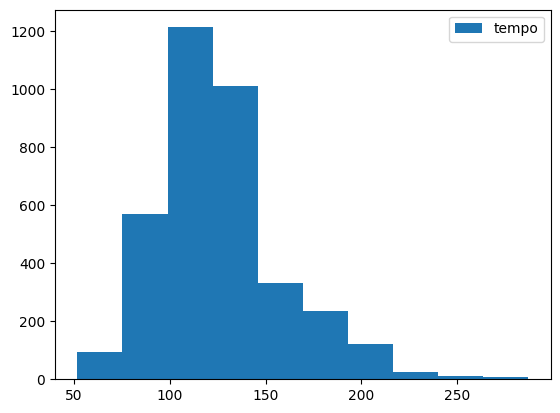

In [ ]:
plt.hist(df['tempo'], bins=10, label='tempo')
plt.legend()
plt.show()

In [ ]:
(df["num_words"] == 0).sum() / df.shape[0]

0.13383002207505518

In [ ]:
df.drop(columns = "path", inplace = True)

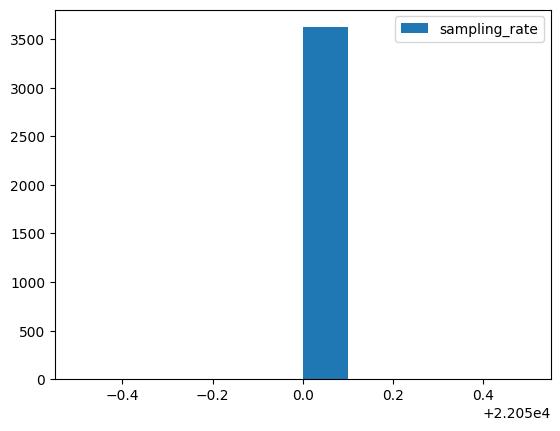

In [ ]:
plt.hist(df['sampling_rate'], bins=10, label='sampling_rate')
plt.legend()
plt.show()

In [ ]:
df.drop(columns = "sampling_rate", inplace = True)

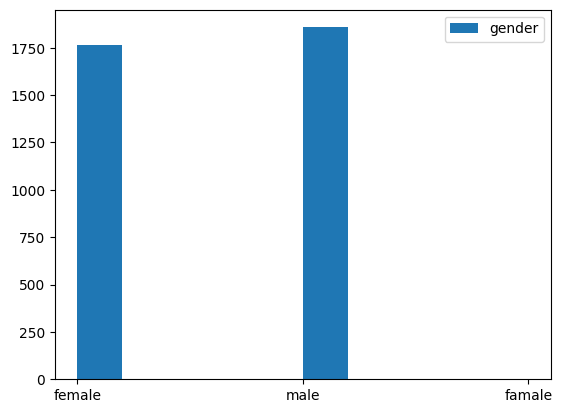

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.hist(df['gender'], bins=10, label='gender')
plt.legend()
plt.show()
plt.savefig('gender.svg')

In [ ]:
(df["gender"] == "famale").sum()

1

In [ ]:
df['gender'] = df['gender'].replace('famale', 'female')

(df["gender"] == "famale").sum()

0

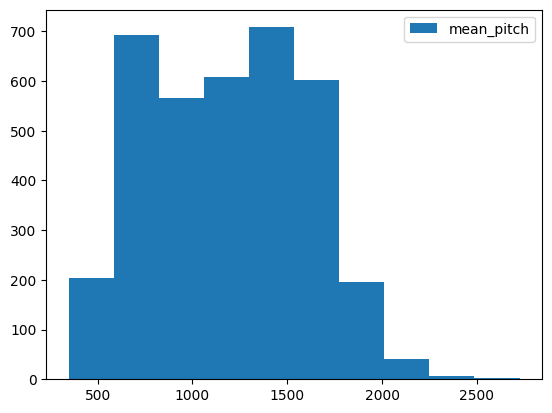

In [ ]:
plt.hist(df['mean_pitch'], bins=10, label='mean_pitch')
plt.legend()
plt.show()

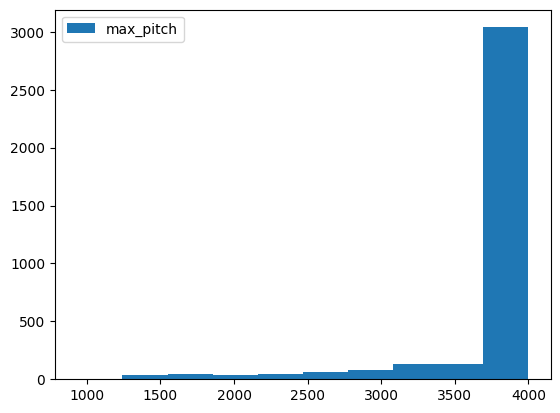

In [ ]:
plt.hist(df['max_pitch'], bins=10, label='max_pitch')
plt.legend()
plt.show()

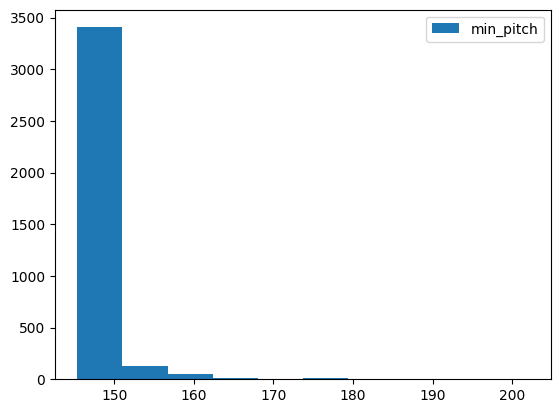

In [ ]:
plt.hist(df['min_pitch'], bins=10, label='min_pitch')
plt.legend()
plt.show()

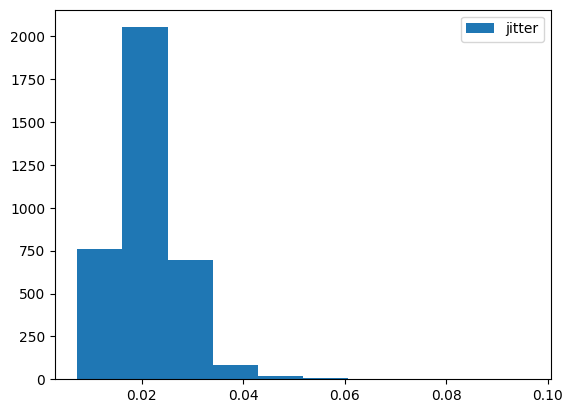

In [ ]:
plt.hist(df['jitter'], bins=10, label='jitter')
plt.legend()
plt.show()

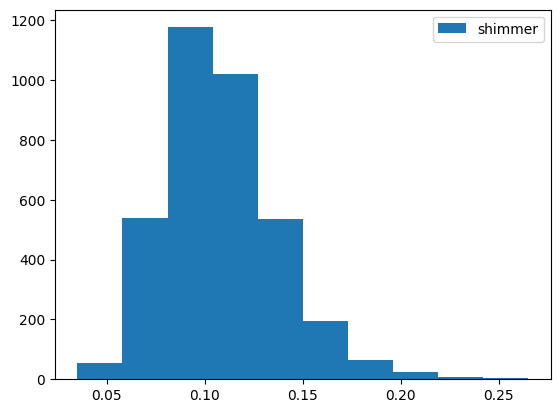

In [ ]:
plt.hist(df['shimmer'], bins=10, label='shimmer')
plt.legend()
plt.show()

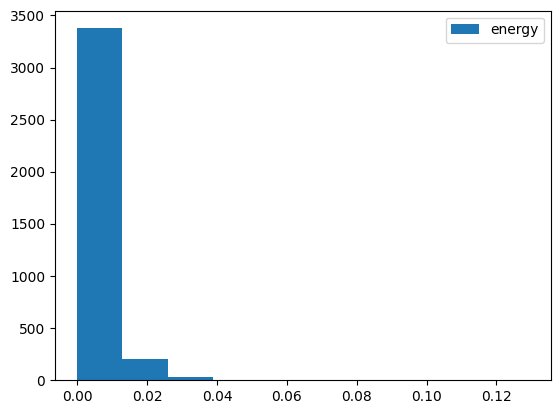

In [ ]:
plt.hist(df['energy'], bins=10, label='energy')
plt.legend()
plt.show()

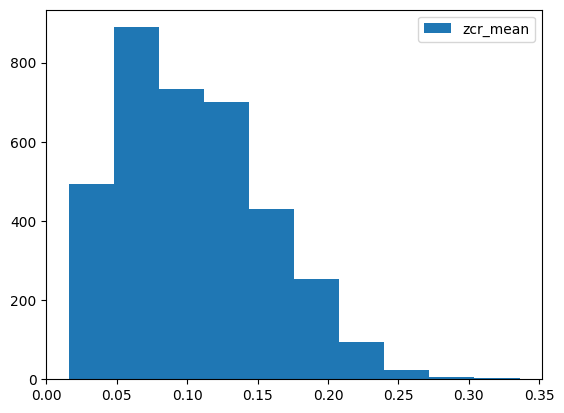

In [ ]:
plt.hist(df['zcr_mean'], bins=10, label='zcr_mean')
plt.legend()
plt.show()

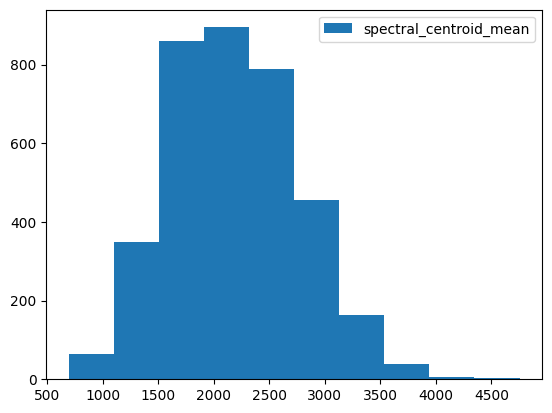

In [ ]:
plt.hist(df['spectral_centroid_mean'], bins=10, label='spectral_centroid_mean')
plt.legend()
plt.show()

##2.3 Changing categorical to numerical

In [ ]:
df_1h = pd.get_dummies(df, columns=['gender', 'ethnicity'])

In [ ]:
print(df.shape, df_1h.shape)

(3624, 98) (3624, 319)


##2.4 Splitting the data

In [ ]:
train_valid_mask = ~df_1h["age"].isna()

feature_names = df_1h[train_valid_mask].drop(columns=["age"]).columns

X = df_1h.drop(columns=["age"]).values
y = df_1h["age"].values

X_train_valid = X[train_valid_mask]
y_train_valid = y[train_valid_mask]
X_test = X[~train_valid_mask]
y_test = y[~train_valid_mask]

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=42)

In [ ]:
X_train.shape

(2199, 318)

#3. Random Forest

In [ ]:
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train , y_train)
np.sqrt(mean_squared_error(y_valid, reg.predict(X_valid)))

9.68390224570445

##3.1 Hyperparameter tuning

In [ ]:
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_split": [2,4],
    "min_samples_leaf": [4,6],
    "max_features": ["sqrt",1.0],
}

grid_search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred = best_model.predict(X_valid)
test_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

print("Best Parameters:", best_params)
print("Test RMSE:", test_rmse)

In [ ]:
reg = RandomForestRegressor(
          max_depth=None,
          max_features=1.0,
          min_samples_leaf=6,
          min_samples_split=2,
          n_estimators=250,
          random_state=42)

reg.fit(X_train , y_train)

y_pred_rf = reg.predict(X_valid)

np.sqrt(mean_squared_error(y_valid, reg.predict(X_valid)))

9.60514587546632

In [ ]:
predictions = reg.predict(X_test)
predictions_df = pd.DataFrame({
    'Id': range(len(X_test)),
    'Predicted': predictions
})
predictions_df.to_csv('predictions_rf.csv', index=False)

In [ ]:
importances_dict = dict(zip(feature_names,reg.feature_importances_))

threshold = 0.001

columns_to_remove = [feature for feature, importance in importances_dict.items() if importance <= threshold]

df_cleaned = df_1h.drop(columns=columns_to_remove)
print(df_cleaned.columns)

In [ ]:
train_valid_mask = ~df["age"].isna()

feature_names = df_cleaned[train_valid_mask].drop(columns=["age"]).columns

X = df_cleaned.drop(columns=["age"]).values
y = df_cleaned["age"].values

X_train_valid = X[train_valid_mask]
y_train_valid = y[train_valid_mask]
X_test = X[~train_valid_mask]
y_test = y[~train_valid_mask]
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=42)

##3.2 Feature importance

In [ ]:
 sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1],reverse=True)

#4. XGBoost

In [ ]:
x_g_boost = XGBRegressor(
    n_estimators=285,
    learning_rate=0.06,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    objective='reg:squarederror',
    random_state=42
)

x_g_boost.fit(X_train, y_train)

y_pred_xgb = x_g_boost.predict(X_valid)

np.sqrt(mean_squared_error(y_valid, y_pred_xgb))

9.428036967434101

In [ ]:
predictions = x_g_boost.predict(X_test)

predictions_df = pd.DataFrame({
    'Id': range(len(X_test)),
    'Predicted': predictions
})

predictions_df.to_csv('predictions_xgb.csv', index=False)

##4.1 Feature importance

In [ ]:
importances_dict = dict(zip(feature_names, x_g_boost.feature_importances_))
sorted_importances = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

In [ ]:
threshold = 0.0001
columns_to_remove = [feature for feature, importance in importances_dict.items() if importance <= threshold]

df_cleaned = df_1h.drop(columns=columns_to_remove)
train_valid_mask = ~df["age"].isna()

feature_names = df_cleaned[train_valid_mask].drop(columns=["age"]).columns

X = df_cleaned.drop(columns=["age"]).values
y = df_cleaned["age"].values

X_train_valid = X[train_valid_mask]
y_train_valid = y[train_valid_mask]
X_test = X[~train_valid_mask]
y_test = y[~train_valid_mask]

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, shuffle=True, random_state=42
)

x_g_boost.fit(X_train, y_train)

y_pred_cleaned = x_g_boost.predict(X_valid)
print(f"RMSE after filtering: {np.sqrt(np.mean((y_valid - y_pred_cleaned) ** 2))}")

##4.2 Hyperparameters tuning

In [ ]:
xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

With new hyperparameters

In [ ]:
x_g_boost_grid = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

x_g_boost_grid.fit(X_train, y_train)

y_pred_grid = x_g_boost_grid.predict(X_valid)

np.sqrt(mean_squared_error(y_valid, y_pred_grid))



In [ ]:
predictions = x_g_boost.predict(X_test)

predictions_df = pd.DataFrame({
    'Id': range(len(X_test)),
    'Predicted': predictions
})

predictions_df.to_csv('predictions.csv', index=False)

#5. Linear regression

In [ ]:
from sklearn.linear_model import Lasso, Ridge

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

lasso = Lasso(random_state=42)

grid_search_lasso = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

grid_search_lasso.fit(X_train, y_train)
lasso_best_alpha = grid_search_lasso.best_params_['alpha']
lasso_best_model = grid_search_lasso.best_estimator_
y_pred_lasso = lasso_best_model.predict(X_valid)
lasso_test_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_lasso))
print(f"Best Alpha: {lasso_best_alpha}, Validation RMSE: {lasso_test_rmse}")

ridge = Ridge(random_state=42)

grid_search_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

grid_search_ridge.fit(X_train, y_train)
ridge_best_alpha = grid_search_ridge.best_params_['alpha']
ridge_best_model = grid_search_ridge.best_estimator_
y_pred_ridge = ridge_best_model.predict(X_valid)
ridge_test_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_ridge))
print(f"Best Alpha: {ridge_best_alpha}, Validation RMSE: {ridge_test_rmse}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.076e+04, tolerance: 3.820e+01
  model = cd_fast.enet_coordinate_descent(


Best Alpha: 0.01, Validation RMSE: 9.977460469314689
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Alpha: 10, Validation RMSE: 10.011900211157492


In [ ]:
predictions_lasso = grid_search_lasso.predict(X_test)

predictions_lasso_df = pd.DataFrame({
    'Id': range(len(X_test)),
    'Predicted': predictions_lasso
})

predictions_lasso_df.to_csv('predictions_lasso.csv', index=False)

In [ ]:
predictions_ridge = grid_search_ridge.predict(X_test)

predictions_ridge_df = pd.DataFrame({
    'Id': range(len(X_test)),
    'Predicted': predictions_ridge
})

predictions_ridge_df.to_csv('predictions_ridge.csv', index=False)

#6. Result visualization

In [ ]:
import seaborn as sns
sns.set_style(
    style='darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

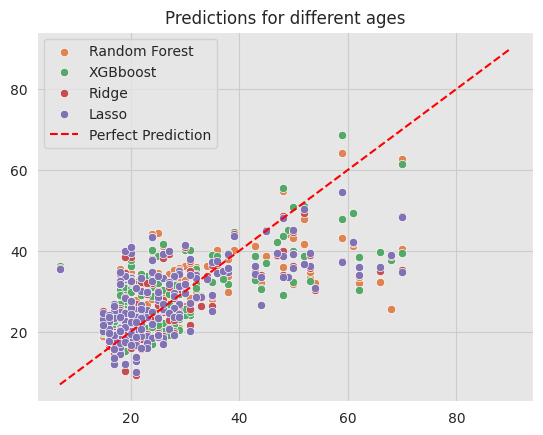

In [ ]:
fig, ax = plt.subplots()
ids = np.arange(200)

sns.scatterplot(x=y_valid[0:200], y=y_pred_rf[0:200], color=sns_c[1], ax=ax, label='Random Forest')
sns.scatterplot(x=y_valid[0:200], y=y_pred_xgb[0:200], color=sns_c[2], ax=ax, label='XGBboost')
sns.scatterplot(x=y_valid[0:200], y=y_pred_ridge[0:200], color=sns_c[3], ax=ax, label='Ridge')
sns.scatterplot(x=y_valid[0:200], y=y_pred_lasso[0:200], color=sns_c[4], ax=ax, label='Lasso')
y_min, y_max = min(y_valid), max(y_valid)
sns.lineplot(x=[y_min, y_max], y=[y_min, y_max], color='red', linestyle='--', label="Perfect Prediction", ax=ax)
ax.legend(loc='upper left')
ax.set(title='Predictions for different ages');
plt.savefig('Predictions.svg')